## Using The Super Resolution Convolutional Neural Network for Image Restoration

  The goal of super-resolution (SR) is to recover a high resolution image from a low resolution input, or as they might say on any modern crime show, **enhance!** 

To accomplish this goal, we will be deploying the super-resolution convolution neural network (SRCNN) using Keras.  This network was published in the paper, "Image Super-Resolution Using Deep Convolutional Networks" 

As the title suggests, the SRCNN is a deep convolutional neural network that learns end-to-end mapping of low resolution to high resolution images.  As a result, we can use it to improve the image quality of low resolution images.  To evaluate the performance of this network, we will be using three image quality metrics: peak signal to noise ratio (PSNR), mean squared error (MSE), and the structural similarity (SSIM) index.  

Furthermore, we will be using OpenCV, the Open Source Computer Vision Library.  OpenCV was originally developed by Intel and is used for many real-time computer vision applications. 

 In this particular project, we will be using it to pre and post process our images.  As you will see later, we will frequently be converting our images back and forth between the RGB, BGR, and YCrCb color spaces.  This is necessary because the SRCNN network was trained on the luminance (Y) channel in the YCrCb color space.  

During this project, you will learn how to: 

* use the PSNR, MSE, and SSIM image quality metrics,
* process images using OpenCV,
* convert between the RGB, BGR, and YCrCb color spaces,
* build deep neural networks in Keras,
* deploy and evaluate the SRCNN network

### 1. Importing Packages
Let's dive right in! In this first cell, we will import the libraries and packages we will be using in this project and print their version numbers.  This is an important step to make sure we are all on the same page; furthermore, it will help others reproduce the results we obtain. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import cv2
import h5py
import numpy
import tarfile
import matplotlib.pyplot as plt
from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Input,Activation, BatchNormalization
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
import numpy as np
import math

from skimage.metrics import structural_similarity as ssim

###**Image Quality Metrics**:
To start, lets define a couple of functions that we can use to calculate the PSNR, MSE, and SSIM.  The structural similiarity (SSIM) index was imported directly from the scikit-image library; however, we will have to define our own functions for the PSNR and MSE.  Furthermore, we will wrap all three of these metrics into a single function that we can call later.    

### Preparing Images

# For this project, we will be using images from https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz . 

In [3]:
!wget 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'

--2021-07-21 10:43:01--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22211847 (21M) [application/x-tar]
Saving to: ‘BSDS300-images.tgz’

BSDS300-images.tgz  100%[===================>]  21.18M  4.96MB/s    in 3.9s    

2021-07-21 10:43:05 (5.37 MB/s) - ‘BSDS300-images.tgz’ saved [22211847/22211847]



In [4]:
print("Extracting data")
with tarfile.open('/content/BSDS300-images.tgz') as tar:
    for item in tar:
        tar.extract(item, '/content/dataset')

Extracting data


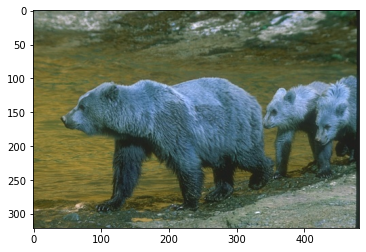

In [5]:
### view the training image
img = cv2.imread('/content/dataset/BSDS300/images/train/100075.jpg')
plt.imshow(img)
plt.show()

In [6]:
DATA_PATH = "/content/dataset/BSDS300/images/train/"
TEST_PATH = "/content/dataset/BSDS300/images/test/"
Random_Crop = 30
Patch_size = 32
label_size = 20
conv_side = 6
scale = 2

def prepare_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = numpy.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=numpy.double)
    label = numpy.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=numpy.double)

    for i in range(nums):
        name = _path + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (int (shape[1] / scale) ,int (shape[0] / scale)))
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        # produce Random_Crop random coordinate to crop training img
        Points_x = numpy.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)
        Points_y = numpy.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)

        for j in range(Random_Crop):
            lr_patch = lr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]
            hr_patch = hr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]

            lr_patch = lr_patch.astype(float) / 255.
            hr_patch = hr_patch.astype(float) / 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]
    return data, label

# BORDER_CUT = 8
BLOCK_STEP = 16
BLOCK_SIZE = 32


def prepare_crop_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = []
    label = []

    for i in range(nums):
        name = _path + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]
        shape = hr_img.shape

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (int (shape[1] / scale) , int (shape[0] / scale)))
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        width_num = int ((shape[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)
        height_num = int ((shape[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)
        for k in range(width_num):
            for j in range(height_num):
                x = k * BLOCK_STEP
                y = j * BLOCK_STEP
                hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
                lr_patch = lr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]

                lr_patch = lr_patch.astype(float) / 255.
                hr_patch = hr_patch.astype(float) / 255.

                lr = numpy.zeros((1, Patch_size, Patch_size), dtype=numpy.double)
                hr = numpy.zeros((1, label_size, label_size), dtype=numpy.double)

                lr[0, :, :] = lr_patch
                hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

                data.append(lr)
                label.append(hr)

    data = numpy.array(data, dtype=float)
    label = numpy.array(label, dtype=float)
    return data, label


def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(numpy.float32)
    y = labels.astype(numpy.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()


def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
        label = numpy.array(hf.get('label'))
        train_data = numpy.transpose(data, (0, 2, 3, 1))
        train_label = numpy.transpose(label, (0, 2, 3, 1))
        return train_data, train_label

data, label = prepare_crop_data(DATA_PATH)
write_hdf5(data, label, "train.h5")
data, label = prepare_data(TEST_PATH)
write_hdf5(data, label, "test.h5")

In [7]:
def psnr(target, ref):
    # assume RGB image
    target_data = numpy.array(target, dtype=float)
    ref_data = numpy.array(ref, dtype=float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(numpy.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

**SRCNN MODEL CREATION**

In [8]:
SRCNN = Sequential()
SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
adam = Adam(learning_rate=0.0003)
SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

In [9]:
SRCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [10]:
data, label = read_training_data("train.h5")
val_data, val_label = read_training_data("test.h5")

checkpoint = ModelCheckpoint("SRCNN_check.h5", monitor='val_loss', verbose=1, save_best_only=True,
                            save_weights_only=False, mode='min')
callbacks_list = [checkpoint]

SRCNN.fit(data, label, validation_data=(val_data, val_label),
              callbacks=callbacks_list, shuffle=True, epochs=10, verbose=1)

Epoch 1/10
3150/3150 [==============================] - 56s 4ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0023 - val_mean_squared_error: 0.0023

Epoch 00001: val_loss improved from inf to 0.00227, saving model to SRCNN_check.h5
Epoch 2/10
3150/3150 [==============================] - 13s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0022 - val_mean_squared_error: 0.0022

Epoch 00002: val_loss improved from 0.00227 to 0.00223, saving model to SRCNN_check.h5
Epoch 3/10
3150/3150 [==============================] - 13s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0022 - val_mean_squared_error: 0.0022

Epoch 00003: val_loss did not improve from 0.00223
Epoch 4/10
3150/3150 [==============================] - 13s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0022 - val_mean_squared_error: 0.0022

Epoch 00004: val_loss improved from 0.00223 to 0.00221, saving model to SRCNN_check.h5
Epoch 5/10
3150/3150 [======

In [11]:
SRCNN.evaluate(val_data, val_label,verbose=1)

94/94 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022


[0.0021589254029095173, 0.0021589254029095173]

**PREDICTION / RECONSTRUCTION OF NEW UNSEEN LR IMAGE**

---



In [12]:
SRCNN.load_weights("/content/drive/MyDrive/MINI PROJECT/SRCNN_3_layer.h5")
#SRCNN.load_weights("/content/SRCNN_check.h5")
IMG_NAME = "/content/drive/MyDrive/MINI PROJECT/new_flower_test.png"
INPUT_NAME = "/content/low.jpg"
OUTPUT_NAME = "pre2.jpg"

img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
shape = img.shape
Y_img = cv2.resize(img[:, :, 0], (int (shape[1] / 2), int (shape[0] / 2)), cv2.INTER_CUBIC)
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
img[:, :, 0] = Y_img
img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
cv2.imwrite(INPUT_NAME, img)

Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
Y[0, :, :, 0] = Y_img.astype(float) / 255.
pre = SRCNN.predict(Y, batch_size=1) * 255.
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(numpy.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
cv2.imwrite(OUTPUT_NAME, img)

# psnr calculation:
im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
im2 = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
im3 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]

print('High Resolution test image and degraded image  : ')
print('PSNR : ',cv2.PSNR(im1, im2))
print('MSE : ',mse(im1, im2))
print('SSIM : ',ssim(im1, im2, multichannel =True))

print("\nHigh Resolution test image and SRCNN reconstructed image :")
print('PSNR : ',cv2.PSNR(im1, im3))
print('MSE : ',mse(im1, im3))
print('SSIM : ',ssim(im1, im3, multichannel =True))

High Resolution test image and degraded image  : 
PSNR :  28.06178205504457
MSE :  101.60197622996131
SSIM :  0.8853040552350142

High Resolution test image and SRCNN reconstructed image :
PSNR :  31.02739007541825
MSE :  51.32646489773355
SSIM :  0.9254060837291983


In [13]:
print('--------------------------------------- ')
print('PSNR : ',cv2.PSNR(im1, im1))
print('MSE : ',mse(im1, im1))
print('SSIM : ',ssim(im1, im1, multichannel =True))

--------------------------------------- 
PSNR :  361.20199909921956
MSE :  0.0
SSIM :  1.0


Text(0.5, 1.0, 'SRCNN')

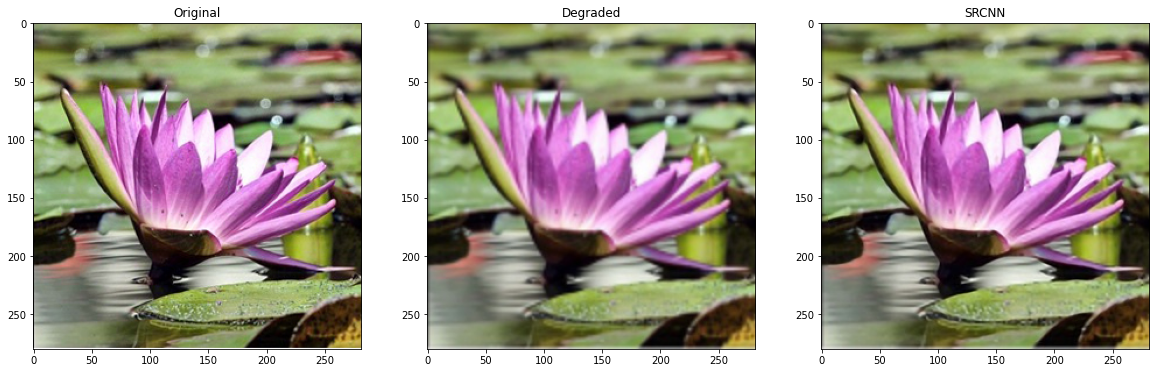

In [14]:
im1 = cv2.imread(IMG_NAME)
im2 = cv2.imread(INPUT_NAME)
im3 = cv2.imread(OUTPUT_NAME)

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

In [15]:
# Extracts the outputs of all layers
layer_outputs = [layer.output for layer in SRCNN.layers[0:]] 
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=SRCNN.input, outputs=layer_outputs)

In [16]:
activations = activation_model.predict(Y)

(1, 272, 274, 128)


Convolution Layer 1




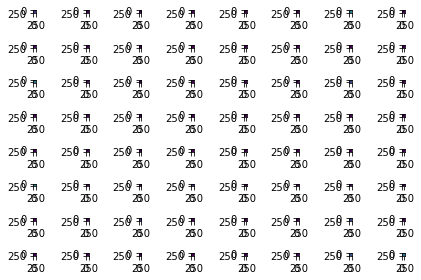

In [17]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
print("\n\nConvolution Layer 1\n\n")

fig=plt.figure()
axes=[]
for i in range(64):
  axes.append( fig.add_subplot(8, 8, i+1) )
  plt.imshow(first_layer_activation[0, :, :,i])
fig.tight_layout()   
plt.show()


(1, 272, 274, 64)


Convolution Layer 2




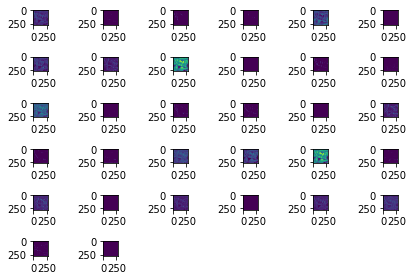

In [18]:
second_layer_activation = activations[1]
print(second_layer_activation.shape)
print("\n\nConvolution Layer 2\n\n")
fig=plt.figure()
axes=[]
for i in range(32):
  axes.append( fig.add_subplot(6, 6, i+1) )
  plt.imshow(second_layer_activation[0, :, :,i])
fig.tight_layout()   
plt.show()


(1, 268, 270, 1)


Convolution Layer 3




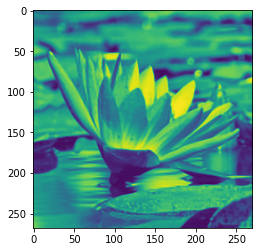

In [19]:
third_layer_activation = activations[2]
print(third_layer_activation.shape)
print("\n\nConvolution Layer 3\n\n")
plt.imshow(third_layer_activation[0, :, :,0])   
plt.show()